## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(414341)

# DP parameters
x_dim = 2
k_approx = 5
num_obs = 1000

# prior parameters
alpha = 1.2 # DP parameter
prior_mu = np.zeros(x_dim)
prior_info = 1.0 * np.eye(x_dim)

info_x = 1.0 * np.eye(x_dim)

x, true_mu, true_z, true_z_ind, true_v, true_pi = \
            dp.draw_data(alpha, prior_mu, prior_info, info_x, x_dim, k_approx, num_obs)

observed mixture proportions: 
 [ 0.071  0.144  0.348  0.046  0.391]
true mixture proportions: 
 [ 0.06972666  0.14855883  0.3397329   0.05271501  0.38926659]


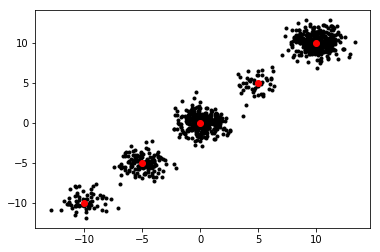

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_approx):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

## Initialize

In [7]:
## initialize VB params

true_init = True

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_par_vec = vb_params.get_free()
global_init_par_vec = vb_params['global'].get_free()

## Run CAVI 

In [8]:
print(vb_params['global']['mu'].get())

[[  2.51053782e-01   7.39777307e-04]
 [  7.63700741e-01   5.97759458e-01]
 [  1.02695060e-01   3.40096960e-01]
 [  6.42636994e-01   3.26807581e-01]
 [  9.23665506e-01   2.48542020e-01]]


In [12]:
def run_cavi(model, init_par_vec, max_iter = 100, tol = 1e-8, disp = True): 
    
    x = model.x
    prior_mu, prior_info, info_x, alpha = dp.get_prior_params(model.prior_params)
    
    # initialize
    model.vb_params.set_free(init_par_vec)
    model.get_kl(verbose = True)
       
    kl = np.zeros(max_iter)
    diff = -10
    
    for i in range(max_iter): 
        
        # tau update
        e_z = model.vb_params['local']['e_z'].get()
        
        tau_new = dp.tau_update(e_z, alpha)
        model.vb_params['global']['v_sticks'].alpha.set(tau_new)
        model.get_kl(verbose = True)
        
        # mu update
        mu_new, info_new = dp.mu_update(x, e_z, prior_mu, prior_info, info_x)
        model.vb_params['global']['mu'].set(mu_new)
        # model.vb_params['global']['info'].set(info_new)  
        model.get_kl(verbose = True)        
            
        # z update
        e_log_v = model.vb_params['global']['v_sticks'].e_log()[:,0] # E[log v]
        e_log_1mv = model.vb_params['global']['v_sticks'].e_log()[:,1] # E[log 1 - v]
        mu = model.vb_params['global']['mu'].get()
        info = model.vb_params['global']['info'].get()
              
        e_z_new = dp.z_update(mu, info, x, info_x, e_log_v, e_log_1mv)
        model.vb_params['local']['e_z'].set(e_z_new)
        model.get_kl(verbose = True)
        
        # evaluate elbo
        kl[i] = model.get_kl()
        
        if i > 0:
            diff = kl[i] - kl[i-1]

        if disp:
            print('iteration: ', i, 'kl: ', kl[i])

        if np.isnan(kl[i]):
            print('NAN ELBO.')
            break

        #if (i > 0) & (diff > 0):
        #    print('kl increased!  Difference: ', diff)
        #    break
        
        #if (np.abs(diff) < tol) & (i < max_iter): 
        #    print('CAVI terminated successfully :)')
        #    break
            
    if i == max_iter - 1: 
        print('max iteration reached')

In [13]:
run_cavi(model, init_par_vec, max_iter = 5, tol = 1e-8, disp = True)

kl:	 -994.997539523
kl:	 -1005.37493585
kl:	 -48590.5516465
kl:	 -48590.7702886
iteration:  0 kl:  -48590.7702886
kl:	 -48590.7705357
kl:	 -48590.7735421
kl:	 -48590.7736579
iteration:  1 kl:  -48590.7736579
kl:	 -48590.7736583
kl:	 -48590.7736621
kl:	 -48590.7736623
iteration:  2 kl:  -48590.7736623
kl:	 -48590.7736623
kl:	 -48590.7736623
kl:	 -48590.7736623
iteration:  3 kl:  -48590.7736623
kl:	 -48590.7736623
kl:	 -48590.7736623
kl:	 -48590.7736623
iteration:  4 kl:  -48590.7736623
max iteration reached


In [15]:
model.vb_params['global']['info'].get()

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]]])

In [14]:
print(model.vb_params['global']['mu'].get())

[[ -9.88388082  -9.70441612]
 [ -4.95284835  -5.03901386]
 [  0.08170132  -0.03412863]
 [  4.70951996   4.76401724]
 [ 10.01173032  10.02858648]]


permutation:  [0 1 2 3 4]
true Z (permuted) 
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]]
e_z (rounded) 
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]]
l1 error (after permutation):  [6.0417083890278785e-05, 6.2611503507947779e-05, 3.654002308091172e-05, 4.6611961876857472e-05, 1.2266358413529688e-05]


true A (permuted): 
 [[-10. -10.]
 [ -5.  -5.]
 [  0.   0.]
 [  5.   5.]
 [ 10.  10.]]
poster mean A: 
 [[ -9.8879121   -9.7072583 ]
 [ -4.95423038  -5.04080769]
 [  0.08196861  -0.03402603]
 [  4.71059197   4.76663436]
 [ 10.01180339  10.02863241]]


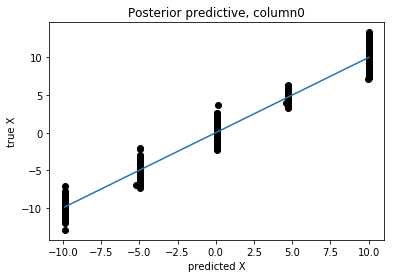

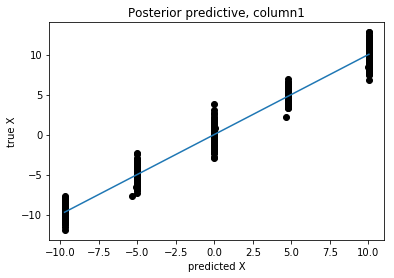

true stick lengths [ 0.06972666  0.15969374  0.43459972  0.1192697   1.        ]
variational stick lengths:  [ 0.07190095  0.15565872  0.44335965  0.10701221]


In [15]:
mu = model.vb_params['global']['mu'].get()
e_z = model.vb_params['local']['e_z'].get()
tau = model.vb_params['global']['v_sticks'].alpha.get()
dp.display_results(x, true_z, true_mu, e_z, mu, true_v, tau, manual_perm = None)

In [16]:
model.set_optimal_z()
e_z = model.vb_params['local']['e_z'].get()
print(np.round(e_z))

[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]]


## Newton Optimization

In [25]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [26]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8, 'disp': True})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

         Current function value: -49862.232657
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 45
         Hessian evaluations: 44
done
-49862.2326573


In [27]:
model.vb_params['global'].set_free(vb_opt.x)

In [28]:
mu = model.vb_params['global']['mu'].get()
model.set_optimal_z()
e_z = model.vb_params['local']['e_z'].get()
dp.display_results(x, true_z, true_mu, e_z, mu, manual_perm = None)

TypeError: display_results() missing 2 required positional arguments: 'true_v' and 'tau'

In [13]:
np.dot(prior_mu, prior_info) + np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92459043e+03,   3.93119813e+03],
       [ -1.42691684e+03,  -1.42802797e+03],
       [  2.21420211e+02,   2.23979301e+02],
       [  2.10572804e-04,   6.31267876e-04],
       [  2.48420648e+01,  -1.39977262e+01]])

In [22]:
 np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92559043e+03,   3.93219813e+03],
       [ -1.42591684e+03,  -1.42702797e+03],
       [  2.22420211e+02,   2.24979301e+02],
       [  1.00021057e+00,   1.00063127e+00],
       [  2.58420648e+01,  -1.29977262e+01]])

In [25]:
np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92459043e+03,   3.93119813e+03],
       [ -1.42691684e+03,  -1.42802797e+03],
       [  2.21420211e+02,   2.23979301e+02],
       [  2.10572804e-04,   6.31267876e-04],
       [  2.48420648e+01,  -1.39977262e+01]])

In [27]:
np.sum(e_z, axis = 0)[1]

214.1255354365253

In [28]:
info_update = np.array([prior_info + np.sum(e_z[:, i]) * info_x \
                            for i in range(k_approx)])

In [29]:
info_update

array([[[ 391.99924641,    0.        ],
        [   0.        ,  391.99924641]],

       [[ 215.12553544,    0.        ],
        [   0.        ,  215.12553544]],

       [[  47.01574032,    0.        ],
        [   0.        ,   47.01574032]],

       [[   1.63235751,    0.        ],
        [   0.        ,    1.63235751]],

       [[ 349.22712063,    0.        ],
        [   0.        ,  349.22712063]]])

In [30]:
sum_e_z = np.sum(e_z, axis = 0)

In [31]:
sum_e_z

array([ 390.99924641,  214.12553544,   46.01574032,    0.63235751,
        348.22712063])

In [35]:
cm = np.cumsum(sum_e_z)

In [41]:
np.concatenate(([0.0], cm[:-1]))

array([   0.        ,  390.99924641,  605.12478185,  651.14052216,
        651.77287967])